In [1]:
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import os
import shutil
import time
import math

from PIL import Image
import numpy as np
import sys

import torch
from torch import nn
from torch.autograd import Variable, Function
from torchvision import models, transforms
import torchvision.models as models
import torchvision.datasets as datasets
import torch.utils.model_zoo as model_zoo
%matplotlib inline
print("mpl backend: ", plt.get_backend())


mpl backend:  module://ipykernel.pylab.backend_inline


In [3]:
torch.cuda.set_device(3)

In [81]:
traindir = '/home/lestsovba/dataset/imagenet/registered/tiny-imagenet-200/train/'
valdir = '/home/lestsovba/dataset/imagenet/registered/tiny-imagenet-200/val/'
testdir = '/home/lestsovba/dataset/imagenet/registered/tiny-imagenet-200/test/'
workers = 4
batch_size = 80

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset = datasets.ImageFolder(
    root=traindir,
    transform=transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

train_dataset_tmp = datasets.ImageFolder(
    root=traindir,
    transform=transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        np.asarray
    ]))

val_dataset = datasets.ImageFolder(
    root=valdir,
    transform=transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True,
    num_workers=workers, pin_memory=True,
    drop_last=True)

train_loader_tmp = torch.utils.data.DataLoader(
    train_dataset_tmp, batch_size=batch_size,
    shuffle=True,
    num_workers=workers, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, shuffle=False,
    num_workers=workers, pin_memory=True, 
    drop_last=True)

"""
test_dataset = datasets.ImageFolder(
    root=testdir,
    transform=transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        normalize,
    ]))

val_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, shuffle=False,
    num_workers=workers, pin_memory=True, 
    drop_last=True)
"""

'\ntest_dataset = datasets.ImageFolder(\n    root=testdir,\n    transform=transforms.Compose([\n        transforms.Resize(64),\n        transforms.CenterCrop(64),\n        transforms.ToTensor(),\n        normalize,\n    ]))\n\nval_loader = torch.utils.data.DataLoader(\n    test_dataset,\n    batch_size=batch_size, shuffle=False,\n    num_workers=workers, pin_memory=True, \n    drop_last=True)\n'

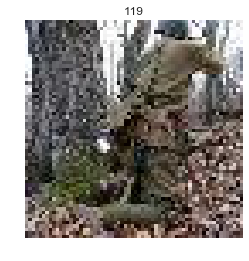

In [8]:
for pics, clss in train_loader_tmp:
    for i in range(batch_size):
        plt.figure()
        plt.imshow(pics[i])
        plt.grid(False)
        plt.title(clss[i])
        plt.axis('off')
        plt.show()
        break
    break

In [76]:
model = vgg11_little(num_classes=200)
model = model.cuda()

In [77]:
#resume='model_best.pth.tar'
resume='vgg_little_ep1.pth.tar'
#resume='vgg11_little_rem_filt.pth.tar'
#resume='new_vgg_little_ep7.pth.tar'

if os.path.isfile(resume):
    print("=> loading checkpoint '{}'".format(resume))
    checkpoint = torch.load(resume)
    start_epoch = checkpoint['epoch']
    best_prec1 = checkpoint['best_prec1']
    print(best_prec1)
    model.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    print("=> loaded checkpoint '{}' (epoch {})"
          .format(resume, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(resume))

=> loading checkpoint 'vgg_little_ep1.pth.tar'
62.56
=> loaded checkpoint 'vgg_little_ep1.pth.tar' (epoch 2)


In [68]:
best_prec1

62.08

In [65]:
criterion = nn.CrossEntropyLoss().cuda()

init_lr = 0.0005
optimizer = torch.optim.SGD(model.parameters(), init_lr,
                            momentum=0.9,
                            weight_decay=1e-4)
#optimizer = torch.optim.Adam(model.parameters())

In [66]:
print_freq = 10
epochs = 30

train_f = open('out_retrain_0_0005.txt', 'w')
val_f = open('out_reval_0_0005.txt', 'w')

if best_prec1 is None:
    best_prec1 = 0
print(best_prec1)

for epoch in range(0, epochs):
    adjust_learning_rate(optimizer, epoch)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch, train_f)

    # evaluate on validation set
    prec1 = validate(val_loader, model, criterion, val_f)

    # remember best prec@1 and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': 'vgg11_little_rem',
        'state_dict': model.state_dict(),
        'best_prec1': prec1,
        'optimizer' : optimizer.state_dict(),
    }, is_best, filename="new_vgg_little_ep{}.pth.tar".format(epoch))
    

train_f.close()
val_f.close()

60.95


Process Process-284:
Process Process-282:
Process Process-283:
Process Process-281:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lestsovba/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lestsovba/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lestsovba/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lestsovba/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lestsovba/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lestsovba/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lestsovba/anaconda3/lib/python3.

KeyboardInterrupt: 

In [79]:
print_freq = 10
epochs = 10
best_prec1 = validate(val_loader, model, criterion, sys.stdout)

Test: [0/125]	Time 0.345 (0.345)	Loss 1.7469 (1.7469)	Prec@1 61.250 (61.250)	Prec@5 81.250 (81.250)
Test: [10/125]	Time 0.091 (0.115)	Loss 3.3310 (2.7134)	Prec@1 32.500 (40.455)	Prec@5 56.250 (66.932)
Test: [20/125]	Time 0.092 (0.104)	Loss 3.9609 (2.8759)	Prec@1 20.000 (38.214)	Prec@5 47.500 (63.869)
Test: [30/125]	Time 0.091 (0.100)	Loss 3.6468 (2.8048)	Prec@1 21.250 (38.871)	Prec@5 56.250 (65.605)
Test: [40/125]	Time 0.092 (0.098)	Loss 3.8588 (2.8671)	Prec@1 23.750 (38.293)	Prec@5 53.750 (64.482)
Test: [50/125]	Time 0.092 (0.097)	Loss 3.2441 (2.9605)	Prec@1 30.000 (37.206)	Prec@5 57.500 (63.088)
Test: [60/125]	Time 0.091 (0.096)	Loss 3.2101 (3.0006)	Prec@1 33.750 (36.619)	Prec@5 66.250 (62.561)
Test: [70/125]	Time 0.092 (0.095)	Loss 3.1108 (3.0073)	Prec@1 37.500 (36.567)	Prec@5 61.250 (62.060)
Test: [80/125]	Time 0.092 (0.095)	Loss 2.7391 (2.9879)	Prec@1 42.500 (36.975)	Prec@5 68.750 (62.361)
Test: [90/125]	Time 0.092 (0.095)	Loss 2.7529 (3.0460)	Prec@1 43.750 (36.085)	Prec@5 66.250 

In [45]:
save_checkpoint({
        'epoch': 1,
        'arch': 'vgg11_rem',
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer' : optimizer.state_dict(),
    }, True, "retrain_model_ranking")


In [14]:
model

VGG(
  (features): Sequential(
    (0): Conv2d (3, 29, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d (29, 37, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d (37, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d (32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (11): Conv2d (256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (16): Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [6]:
def train(train_loader, model, criterion, optimizer, epoch, f):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        #target -= 1
        #print(target, file=f)
        target = target.cuda(async=True)
        input = input.cuda()
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1, top5=top5), file=f)
        f.flush()    

In [5]:
def validate(val_loader, model, criterion, f):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target -= 1
        input = input.cuda(async=True)
        target = target.cuda(async=True)
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data.cpu(), target.cpu(), topk=(1, 5))
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1, top5=top5), file=f)

    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5), file=f)
    f.flush()
    return top5.avg

In [32]:
classifier_size = 512 * 2 * 2

model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(classifier_size, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'LITTLE': [32, 'M', 64, 'M', 128, 128, 'M', 256, 256, 'M', 256, 256, 'M'],
    #'REM': [29, 'M', 37, 'M', 32, 256, 'M', 512, 512, 'M', 512, 512, 'M']
    'REM': [28, 'M', 99, 'M', 152, 256, 'M', 512, 512, 'M', 512, 512, 'M']
}


def vgg11(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A']), **kwargs)
    if pretrained:
        model.load_state_dict( model_zoo.load_url(model_urls['vgg11']))
    return model


def vgg11_little(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A'], batch_norm=False), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11']))
    return model


def vgg11_rem(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['REM'], batch_norm=False), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11']))
    return model

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [44]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')